# Old Stuff

## Old cleaning

In [23]:
import numpy
import pandas as pd
from fairlearn.metrics import *
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
def make_clean_X_y(dataset, label_to_use = "mortality_five_years"):
    y = dataset[label_to_use]
   #drop all data that is completely empty
    # dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    dataset = dataset.drop(columns=["rmonth_survey","ryear_survey","HHID","PN","heart_condition_compared_to_prev", #maybe later just drop 1st heart featuer
                          "mortality_five_years","mortality_ten_years","Key","year_death"]) # this has duplicate
    dataset = dataset.dropna(axis=1, thresh=len(dataset)*0.75)
    return dataset, y

In [22]:
pd.read_pickle("hrs_data_2016.pkl").iloc[0:1].dropna(axis=1, how='all')

,HHID,PN,rmonth_survey,ryear_survey,age,live_nursing_facility,divorce_widow_status,health_status,health_status_compared_to_prev,high_blood_pressure,diabetes,cancer,lung_disease,heart_condition,stroke,psychiatric_emotional_problem,arthritis,pain,alcohol,shortness_breath,fatigue,cough,depressed_x,memory,depressed_y,dependents,type_house,own_or_rent,cooperation,tiredness,employment_status,state_live,gender,year_born_y,leave_inheritance,wave,Key,year_death,mortality_ten_years,mortality_five_years
0,010001,010,5.0,2016.0,76.0,5.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,4.0,2.0,3.0,1.0,5.0,2.0,1.0,1939.0,0.0,13.0,010001-010,0,0,0


In [3]:
small_data_2002_X,small_data_2002_y = make_clean_X_y(pd.read_pickle("hrs_data_2002.pkl").iloc[0:100])
small_data_2004_X,small_data_2004_y = make_clean_X_y(pd.read_pickle("hrs_data_2004.pkl").iloc[0:100])

In [19]:
small_data_2002_X.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             100 non-null    object 
 1   live_nursing_facility           100 non-null    float64
 2   race                            100 non-null    object 
 3   divorce_widow_status            96 non-null     object 
 4   marital_status                  100 non-null    object 
 5   health_status                   100 non-null    float64
 6   health_status_compared_to_prev  100 non-null    object 
 7   high_blood_pressure             100 non-null    float64
 8   diabetes                        100 non-null    float64
 9   cancer                          100 non-null    float64
 10  lung_disease                    100 non-null    float64
 11  heart_condition                 100 non-null    float64
 12  stroke                          100 n

In [4]:
small_data_2002_X.iloc[4]["divorce_widow_status"]==pd.NA

<NA>

In [5]:
full_dataset_X = pd.concat([small_data_2002_X,small_data_2004_X], ignore_index=True)
full_dataset_y = pd.concat([small_data_2002_y,small_data_2004_y], ignore_index=True)

## Old Training Part

In [6]:
def train_with_subset(data_subset_X, data_subset_y, data_full_X,data_full_y, model):
    # (regular) full to full eg. 2002 + all other years tested on 2002 + all other years
    X_train, X_test, y_train, y_test, race_train,race_test = train_test_split(data_full_X, data_full_y,data_full_X["race"], random_state=5)
    model.fit(X_train, y_train)

    # choose more from here: https://fairlearn.org/main/api_reference/generated/fairlearn.metrics.equal_opportunity_difference.html
    metrics_needed = {
        'demo_parity_diff' : demographic_parity_difference,
        'demo_parity_ratio' : demographic_parity_ratio,
        'eq_parity_diff' : equalized_odds_difference,
        'eq_parity_ratio' : equalized_odds_ratio,
        'count' : count
    }
    y_pred = classifier.predict(X_test)
    metric_frame = MetricFrame(
        metrics=metrics_needed, y_true=y_test, y_pred=y_pred, sensitive_features=race_test
    )
    metric_frame.by_group.plot.bar(
        subplots=True,
        layout=[3, 3],
        legend=False,
        figsize=[12, 8],
        title="Show all metrics",
    )

    # just duplicate above code for other sections

    # # subset to subset ex. 2002 only tested on 2002
    # X_train, X_test, y_train, y_test = train_test_split(data_full_X, data_full_y, random_state=5)
    # model.fit(X_train, y_train)

    # # subset to full ex. 2002 tested on 2002 + all other years
    # X_train, X_test, y_train, y_test = train_test_split(data_full_X, data_full_y, random_state=5)
    # model.fit(X_train, y_train)
    
    
    

In [ ]:
## Might need to use the column transformer instead if there's still trouble with imputation
ct = make_column_transformer(
    (
        Pipeline(
            [
                ("imputer", SimpleImputer(strategy="mean")),
                ("normalizer", StandardScaler()),
            ]
        ),
        make_column_selector(dtype_include=number),
    ),
    (
        Pipeline(
            [
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False)),
            ]
        ),
        make_column_selector(dtype_include="category"),
    ),
)

In [ ]:
from fairlearn.reductions import ErrorRate, EqualizedOdds, ExponentiatedGradient

# Control, no fairness (Decision Tree), should be replaceable with RandomForestClassifier()
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant")),
    ("normalizer", StandardScaler()),
    ("clf", classifier),
    ])

train_with_subset(None, None, full_dataset_X,  full_dataset_X, pipe)



In [ ]:
# Expotentiated Gradient constraint, should be replaceable with RandomForestClassifier()

objective = ErrorRate(costs={'fp': 0.1, 'fn': 0.9})
constraint = EqualizedOdds(difference_bound=0.01) # can be changed to other constraints instead 
# see fairlearn.reduction around here: https://fairlearn.org/main/api_reference/generated/fairlearn.reductions.DemographicParity.html
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
mitigator = ExponentiatedGradient(classifier, constraint, objective=objective)

pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant")),
    ("normalizer", StandardScaler()),
    ("clf", mitigator),
    ])

train_with_subset(None, None, full_dataset_X,  full_dataset_X, pipe)

In [ ]:
# Adversarial learning, should be replaceable with RandomForestClassifier()
from fairlearn.adversarial import AdversarialFairnessClassifier

mitigator = AdversarialFairnessClassifier(
    backend="torch",
    predictor_model=[50, "leaky_relu"], # this is number of nodes and then activation function, see here: https://fairlearn.org/main/api_reference/generated/fairlearn.adversarial.AdversarialFairnessClassifier.html#:~:text=a%20BackendEngine%20class.-,predictor_model,-list%2C%20torch.nn
    adversary_model=[3, "leaky_relu"],
    batch_size=2**8,
    progress_updates=0.5,
    random_state=5,
    #contraints = "demographic_parity" # we can chagne this to equalized_odds as per https://fairlearn.org/main/api_reference/generated/fairlearn.adversarial.AdversarialFairnessClassifier.html#:~:text=constraintsstr%2C%20default,demographic_parity%E2%80%99%20or%20%E2%80%98equalized_odds%E2%80%99.
)


pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant")),
    ("normalizer", StandardScaler()),
    ("clf", mitigator),
    ])

train_with_subset(None, None, full_dataset_X,  full_dataset_X, pipe)

# slightly more advanced usage of adversarial training here: https://fairlearn.org/main/auto_examples/plot_adversarial_fine_tuning.html

# (4) Test Fairness on existing dataset

In [1]:
import numpy as np
import pandas as pd
from fairlearn.metrics import *
from fairlearn.reductions import ErrorRate, DemographicParity, ExponentiatedGradient, EqualizedOdds
from fairlearn.adversarial import AdversarialFairnessClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import make_column_transformer, make_column_selector
import sklearn
import time
from functools import partial
import warnings
from sklearn.exceptions import ConvergenceWarning
from tqdm.notebook import tqdm, trange

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')
train_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
id_test_df = data_dict['2012']
ood_test_df = pd.concat([data_dict['2014'], data_dict['2016']], ignore_index=True)



# Separate features and target variable, start with mortality ten years since it's more balanced than five years
X_train = train_df.drop(columns=['mortality_ten_years', 'mortality_five_years', 'year_death', 'HHID', 'PN'])  # Adjust target column
y_train = train_df['mortality_ten_years']

X_id_test = id_test_df.drop(columns=['mortality_ten_years', 'mortality_five_years', 'year_death', 'HHID', 'PN'])
y_id_test = id_test_df['mortality_ten_years']

X_ood_test = ood_test_df.drop(columns=['mortality_ten_years', 'mortality_five_years', 'year_death', 'HHID', 'PN'])
y_ood_test = ood_test_df['mortality_ten_years']



C:\Users\Safi\AppData\Local\Temp\ipykernel_45072\2245039320.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)


## Fairness calculation methods

In [3]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current']

def display_metrics(met_true,met_pred,met_sens):
    zero_div_precision_score = partial(precision_score, zero_division=0)
    metrics_needed = {
        "accuracy": accuracy_score,
        "precision": zero_div_precision_score,
        "false positive rate": false_positive_rate,
        "false negative rate": false_negative_rate,
        "selection rate": selection_rate,
        'count' : count
    }
    metric_frame = MetricFrame(
        metrics=metrics_needed, y_true=met_true, y_pred=met_pred, sensitive_features=met_sens
    )
    metric_frame.by_group.plot.bar(
        subplots=True,
        layout=[3, 3],
        legend=False,
        figsize=[12, 8],
        title="Show all metrics",
    )
    calced_metrics = {        
        'demo_parity_diff' : demographic_parity_difference(met_true,met_pred,sensitive_features=met_sens),
        'demo_parity_ratio' : demographic_parity_ratio(met_true,met_pred,sensitive_features=met_sens),
        'eq_odds_diff' : equalized_odds_difference(met_true,met_pred,sensitive_features=met_sens),
        'eq_odds_ratio' : equalized_odds_ratio(met_true,met_pred,sensitive_features=met_sens),
        'accuracy': accuracy_score(met_true,met_pred)
    }
    df = pd.DataFrame({"metric_value":calced_metrics.values()},
                      index=calced_metrics.keys())

    return df
    # df.plot.bar(
    #     figsize=[12, 8],
    #     title="Calculated metrics",
    # )

## Training Experiments

In [4]:
def train_over_iterations(model, X_data,y_data,iterations, sensitive_a_data=None):
    training_accuracies = []
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        # Train for multiple iterations manually
        for i in tqdm(range(1, iterations + 1)):  # e.g., 10 iterations
            if isinstance(model, Pipeline):
                model[-1].set_params(max_iter=i)
            else:
                model.set_params(max_iter=i)
            if sensitive_a_data is not None:
                model.fit(X_data, y_data, sensitive_features=sensitive_a_data)
            else:
                model.fit(X_data, y_data)
            y_train_pred = model.predict(X_data)
            acc = accuracy_score(y_data, y_train_pred)
            training_accuracies.append(acc)
    
    # Plot training accuracy
    import matplotlib.pyplot as plt
    plt.plot(range(1, len(training_accuracies) + 1), training_accuracies, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Training Accuracy')
    plt.title('Training Accuracy per Iteration')
    plt.show()

### Filled with -999

In [5]:
X_train_filled = X_train.fillna(-999)
X_id_test_filled = X_id_test.fillna(-999)
X_ood_test_filled = X_ood_test.fillna(-999)

C:\Users\Safi\AppData\Local\Temp\ipykernel_45072\2490678140.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train_filled = X_train.fillna(-999)
C:\Users\Safi\AppData\Local\Temp\ipykernel_45072\2490678140.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_id_test_filled = X_id_test.fillna(-999)
C:\Users\Safi\AppData\Local\Temp\ipykernel_45072\2490678140.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the f

  0%|          | 0/100 [00:00<?, ?it/s]

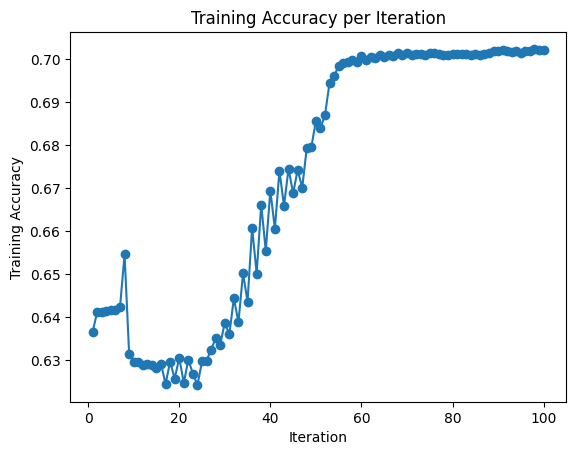

In [6]:
logistic_reg = LogisticRegression(max_iter=1, warm_start=True, random_state=42)
train_over_iterations(logistic_reg, X_train_filled,y_train, 100)

,metric_value
demo_parity_diff,0.223835
demo_parity_ratio,0.426801
eq_odds_diff,0.685069
eq_odds_ratio,0.000000
accuracy,0.702137


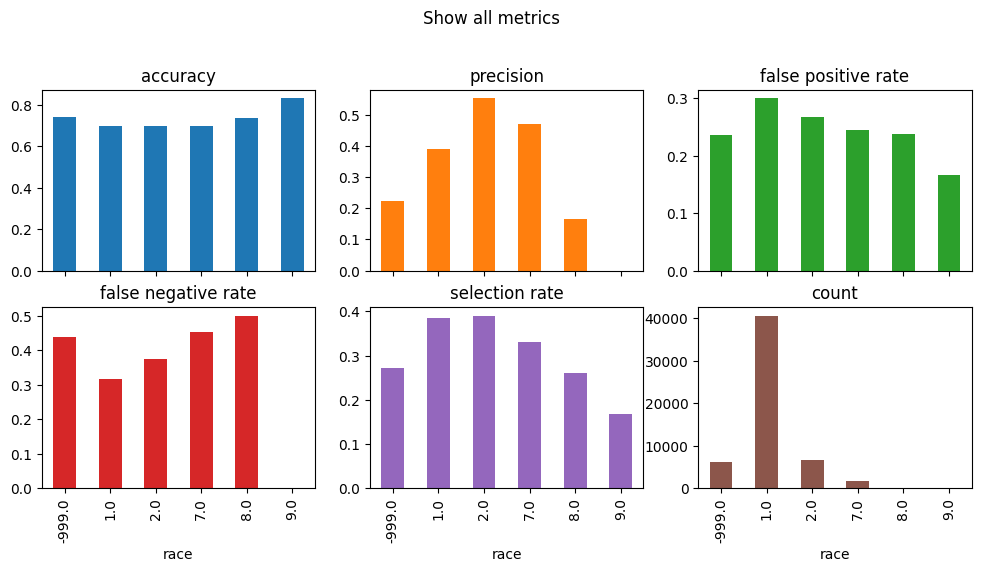

In [7]:
# Show fairness metrics on training
display_metrics(logistic_reg.predict(X_train_filled), y_train, X_train_filled["race"])

,metric_value
demo_parity_diff,0.204545
demo_parity_ratio,0.181818
eq_odds_diff,0.524826
eq_odds_ratio,0.000000
accuracy,0.765809


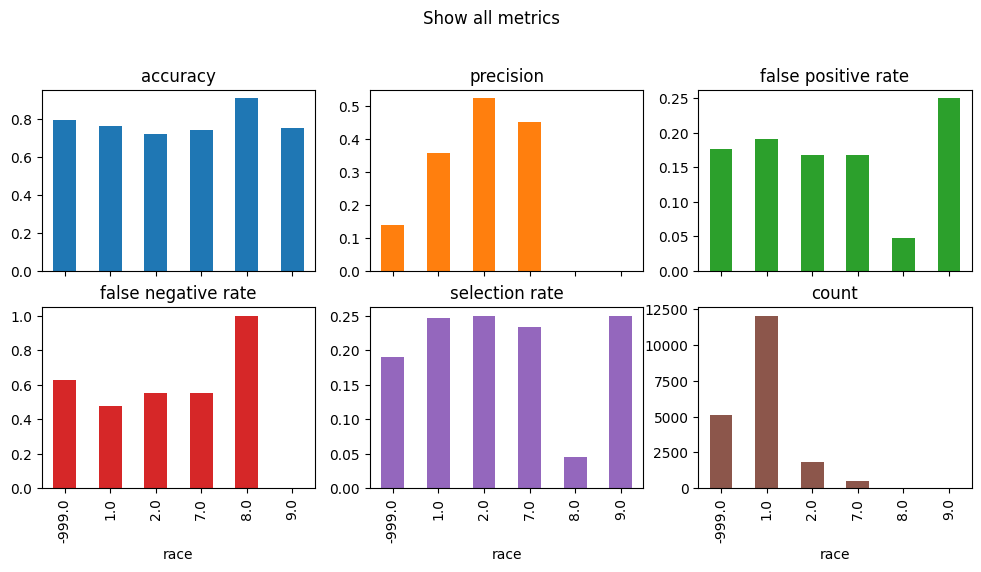

In [8]:
# Show fairness metrics on testing iid
display_metrics(logistic_reg.predict(X_id_test_filled), y_id_test, X_id_test_filled["race"])

,metric_value
demo_parity_diff,0.089119
demo_parity_ratio,0.000000
eq_odds_diff,0.215240
eq_odds_ratio,0.000000
accuracy,0.872985


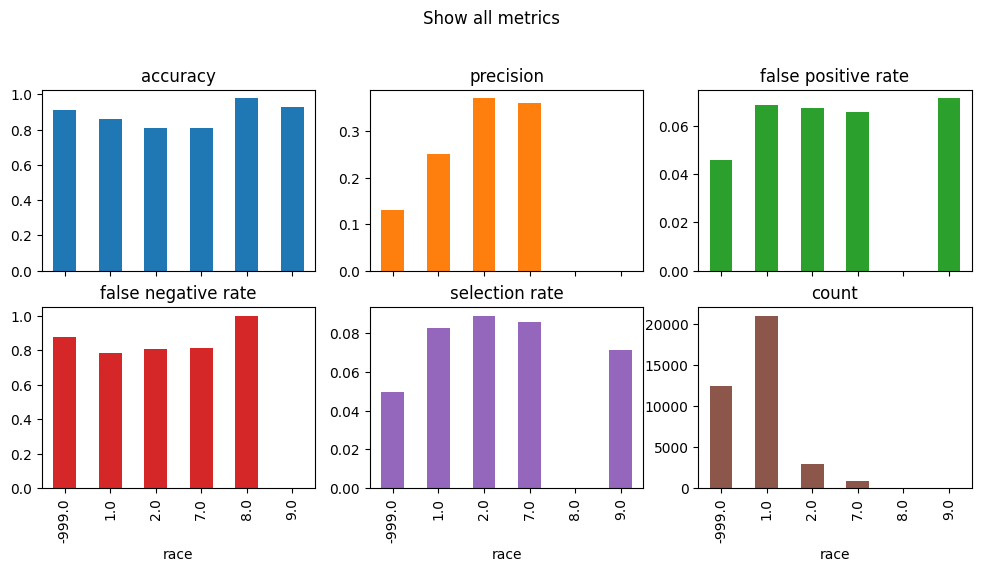

In [9]:
# Show fairness metrics on testing ood
display_metrics(logistic_reg.predict(X_ood_test_filled), y_ood_test, X_ood_test_filled["race"])

### Imputed 

In [10]:
cols_float_type = ["year_born", "financial_expectation_earlier",	"financial_expectation_previous", "financial_expectation_current",
                   "income_earlier", "income_previous", "income_current", "leave_inheritance_earlier", "leave_inheritance_previous",
                   "leave_inheritance_current", "num_children_earlier", "num_children_previous", "num_children_current",
                   "num_dependents_earlier", "num_dependents_previous", "num_dependents_current", "num_drinks_days_per_week_earlier",
                   "num_drinks_days_per_week_previous", "num_drinks_days_per_week_current", "num_drinks_per_day_earlier",
                   "num_drinks_per_day_previous", "num_drinks_per_day_current", "property_value_earlier", "property_value_previous",
                   "property_value_current", "year_property_acquired_earlier", "year_property_acquired_previous",
                   "year_property_acquired_current", "year_retired_earlier", "year_retired_previous", "year_retired_current", "age"]

# change all types to be categorical except the few above that we keep as float64
def fix_dtypes(df):
    df = df.fillna(np.nan).astype("float64")
    for column in df.columns:
        if column not in cols_float_type:
            df[column] = df[column].astype("category")
    return df

In [11]:
imp_norm_pipe = make_column_transformer(
    (
        Pipeline(
            [
                ("imputer", SimpleImputer(strategy="mean",missing_values=pd.NA)),
                ("normalizer", StandardScaler())
            ]
        ),
        make_column_selector(dtype_include="float64"),
    ),
    (
        Pipeline(
            [
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-1)),
            ]
        ),
        make_column_selector(dtype_include="category"),
    ),
)

all_na_cols = X_train.columns[X_train.isna().all()]

X_train_imp = X_train.drop(columns=all_na_cols).fillna(np.nan)
X_train_imp_normed = imp_norm_pipe.fit_transform(fix_dtypes(X_train_imp))

X_id_test_imp = X_id_test.drop(columns=all_na_cols).fillna(np.nan)
X_id_test_imp_normed = imp_norm_pipe.transform(fix_dtypes(X_id_test_imp))

X_ood_test_imp = X_ood_test.drop(columns=all_na_cols).fillna(np.nan)
X_ood_test_imp_normed = imp_norm_pipe.transform(fix_dtypes(X_ood_test_imp))

C:\Users\Safi\AppData\Local\Temp\ipykernel_45072\3635169227.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train_imp = X_train.drop(columns=all_na_cols).fillna(np.nan)
C:\Users\Safi\AppData\Local\Temp\ipykernel_45072\3635169227.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_id_test_imp = X_id_test.drop(columns=all_na_cols).fillna(np.nan)
C:\Users\Safi\AppData\Local\Temp\ipykernel_45072\3635169227.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.

  0%|          | 0/50 [00:00<?, ?it/s]

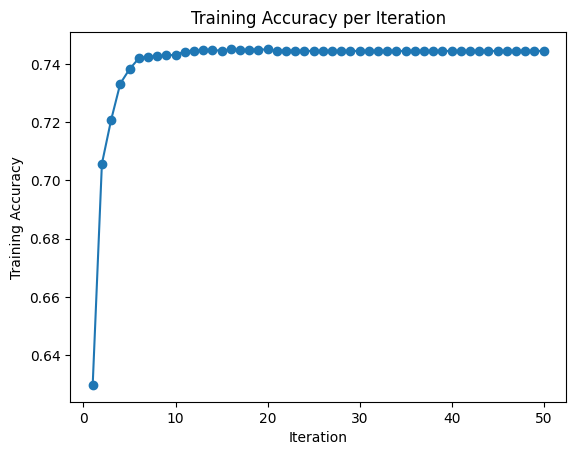

In [12]:
sklearn.set_config(enable_metadata_routing=True)

imputed_logistic_reg = LogisticRegression(max_iter=1, warm_start=True, random_state=42)
train_over_iterations(imputed_logistic_reg, X_train_imp_normed,y_train, 50)

,metric_value
demo_parity_diff,0.223835
demo_parity_ratio,0.426801
eq_odds_diff,0.718991
eq_odds_ratio,0.000000
accuracy,0.744549


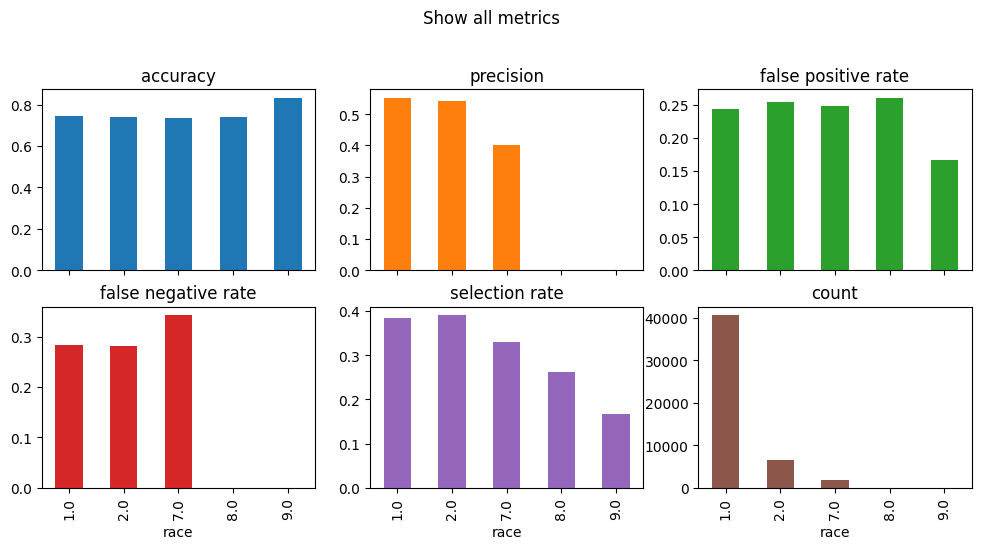

In [13]:
# Show fairness metrics on training
display_metrics(imputed_logistic_reg.predict(X_train_imp_normed), y_train, X_train_imp["race"])

,metric_value
demo_parity_diff,0.204545
demo_parity_ratio,0.181818
eq_odds_diff,0.646678
eq_odds_ratio,0.000000
accuracy,0.798504


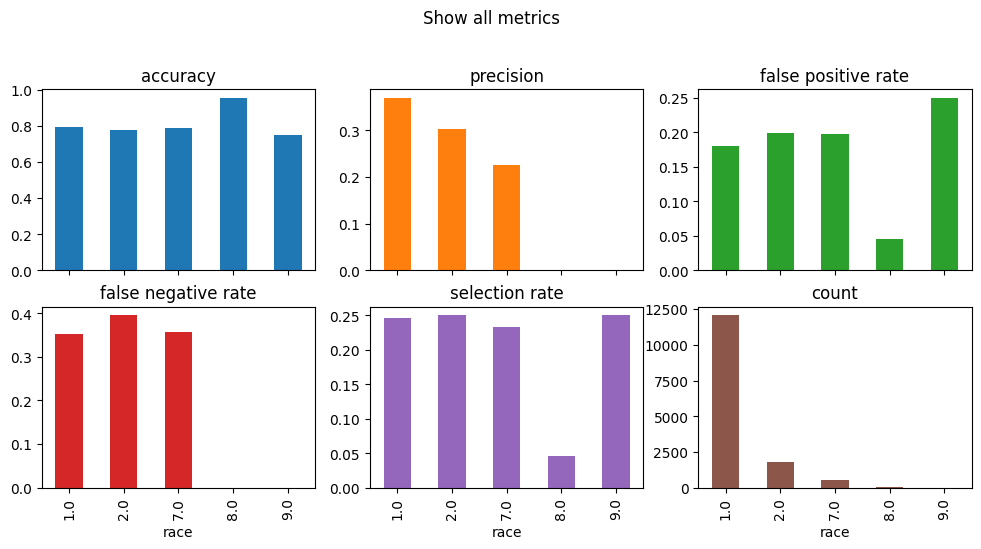

In [14]:
# Show fairness metrics on testing iid
display_metrics(imputed_logistic_reg.predict(X_id_test_imp_normed), y_id_test, X_id_test_imp["race"])

,metric_value
demo_parity_diff,0.089119
demo_parity_ratio,0.000000
eq_odds_diff,0.470588
eq_odds_ratio,0.000000
accuracy,0.911105


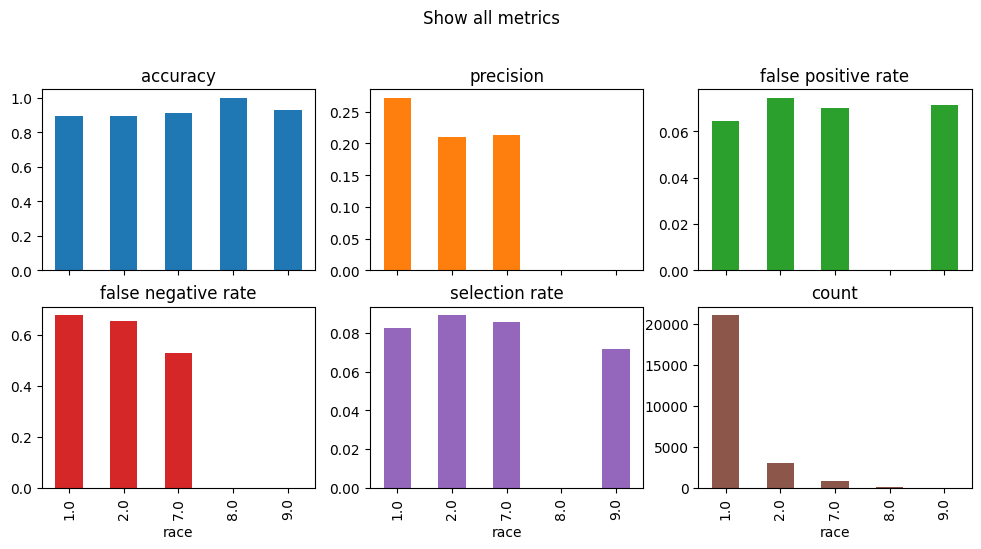

In [15]:
# Show fairness metrics on testing ood
display_metrics(imputed_logistic_reg.predict(X_ood_test_imp_normed), y_ood_test, X_ood_test_imp["race"])

### Imputed MLPClassifier

  0%|          | 0/20 [00:00<?, ?it/s]

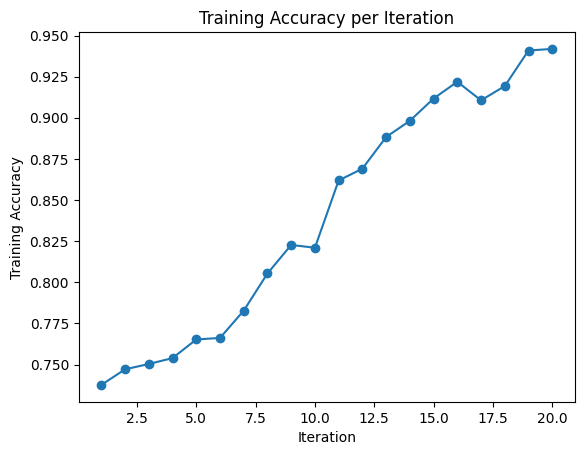

In [16]:
# imputed_mlp_class = MLPClassifier(hidden_layer_sizes=(200,20), learning_rate_init=0.0005,
#                                   max_iter=1, warm_start=True, random_state=42) 92.5
imputed_mlp_class = MLPClassifier(hidden_layer_sizes=(200,30), learning_rate_init=0.0007,
                                   max_iter=1, warm_start=True, random_state=42)
train_over_iterations(imputed_mlp_class, X_train_imp_normed,y_train, 20)

,metric_value
demo_parity_diff,0.223835
demo_parity_ratio,0.426801
eq_odds_diff,0.070893
eq_odds_ratio,0.326514
accuracy,0.941846


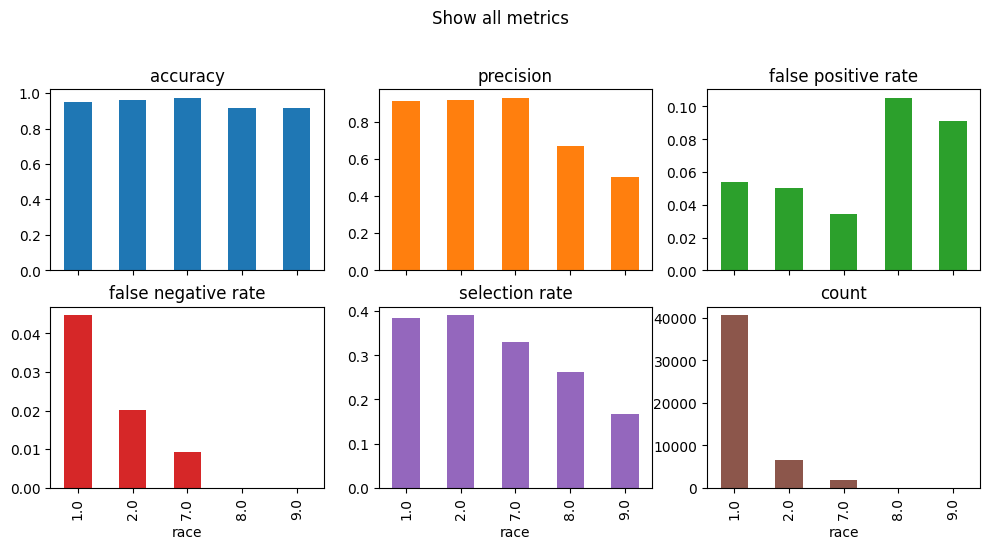

In [17]:
# Show fairness metrics on training
display_metrics(imputed_mlp_class.predict(X_train_imp_normed), y_train, X_train_imp["race"])

,metric_value
demo_parity_diff,0.089119
demo_parity_ratio,0.000000
eq_odds_diff,0.231214
eq_odds_ratio,0.000000
accuracy,0.798185


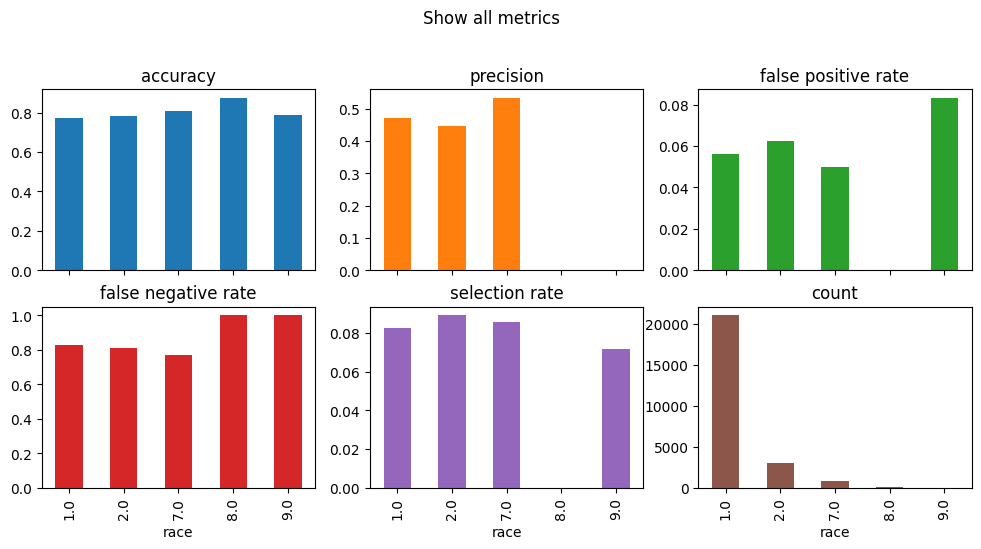

In [18]:
# Show fairness metrics on testing od
display_metrics(imputed_mlp_class.predict(X_ood_test_imp_normed), y_ood_test, X_ood_test_imp["race"])

,metric_value
demo_parity_diff,0.204545
demo_parity_ratio,0.181818
eq_odds_diff,0.468085
eq_odds_ratio,0.000000
accuracy,0.728349


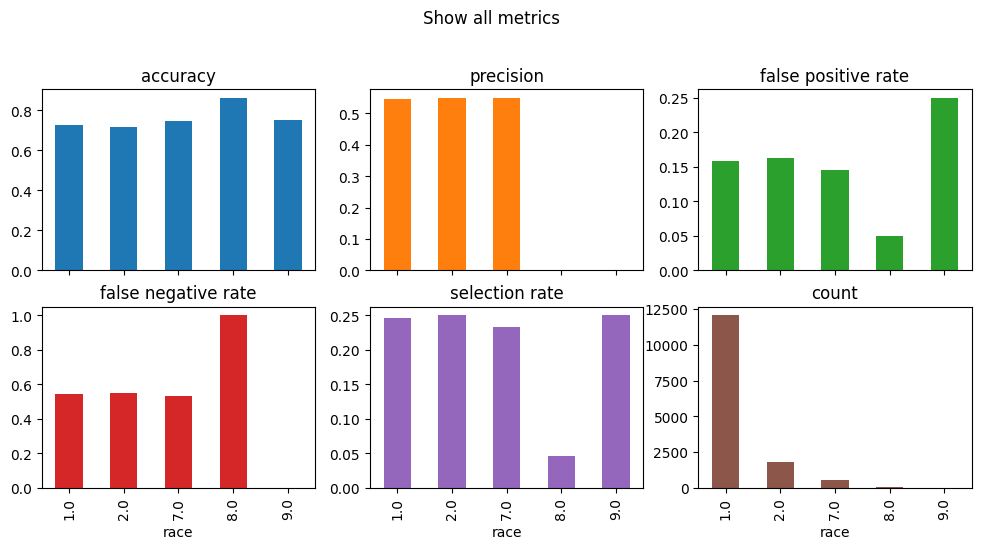

In [19]:
# Show fairness metrics on testing iid
display_metrics(imputed_mlp_class.predict(X_id_test_imp_normed), y_id_test, X_id_test_imp["race"])

### Imputed Exponetiated Gradient

In [20]:
EXP_GRAD_SENS_ATTR = "race"

imp_norm_drop_miss_pipe = make_column_transformer(
    (
        Pipeline(
            [
                ("imputer", SimpleImputer(strategy="mean",missing_values=pd.NA)),
                ("normalizer", StandardScaler())
            ]
        ),
        make_column_selector(dtype_include="float64"),
    ),
    (
        Pipeline(
            [
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-1)),
            ]
        ),
        make_column_selector(dtype_include="category"),
    ),
)


X_train_imp_dropped = X_train_imp[X_train_imp[EXP_GRAD_SENS_ATTR].notna()]
y_train_dropped = y_train[X_train_imp[EXP_GRAD_SENS_ATTR].notna()]
X_train_imp_drop_normed = imp_norm_drop_miss_pipe.fit_transform(fix_dtypes(X_train_imp_dropped))

X_id_test_imp_dropped = X_id_test_imp[X_id_test_imp[EXP_GRAD_SENS_ATTR].notna()]
y_id_test_dropped = y_id_test[X_id_test_imp[EXP_GRAD_SENS_ATTR].notna()]
X_id_test_imp_drop_normed = imp_norm_drop_miss_pipe.transform(fix_dtypes(X_id_test_imp_dropped))

X_ood_test_imp_dropped = X_ood_test_imp[X_ood_test_imp[EXP_GRAD_SENS_ATTR].notna()]
y_ood_test_dropped = y_ood_test[X_ood_test_imp[EXP_GRAD_SENS_ATTR].notna()]
X_ood_test_imp_drop_normed = imp_norm_drop_miss_pipe.transform(fix_dtypes(X_ood_test_imp_dropped))

In [21]:
clf = LogisticRegression(max_iter=20, warm_start=True, random_state=42)
#DecisionTreeClassifier(max_depth=32)#,max_iter=1, warm_start=True)
objective = ErrorRate(costs={'fp': 0.5, 'fn': 0.5})
constraint = DemographicParity(difference_bound=0.01) # can be changed to other constraints instead 
# see fairlearn.reduction around here: https://fairlearn.org/main/api_reference/generated/fairlearn.reductions.DemographicParity.html\
ITERATIONS = 100 # note can't use the train_over_iterations because expotentiatedgradient doesnt allow for multiple fit() calls
exp_gradient_mit = ExponentiatedGradient(clf, constraint, objective=objective, max_iter=ITERATIONS)
start = time.time()
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    exp_gradient_mit.fit(X_train_imp_drop_normed, y_train_dropped, sensitive_features=X_train_imp_dropped[EXP_GRAD_SENS_ATTR])
    y_train_pred = exp_gradient_mit.predict(X_train_imp_drop_normed)
    acc = accuracy_score(y_train_dropped, y_train_pred)
    print(f"Accuracy: {acc}")
    elapsed = time.time() - start
    print(f"Time to execute: {elapsed}, it/s: {ITERATIONS/elapsed}")

# train_over_iterations(mitigator_f, X_train_imp_drop_normed,y_train_dropped, 20,
#                       sensitive_a_data = X_train_imp_dropped[EXP_GRAD_SENS_ATTR])

Accuracy: 0.7298967810370854
Time to execute: 14.433068752288818, it/s: 6.928533475193336


,metric_value
demo_parity_diff,0.089119
demo_parity_ratio,0.000000
eq_odds_diff,0.177358
eq_odds_ratio,0.000000
accuracy,0.749530


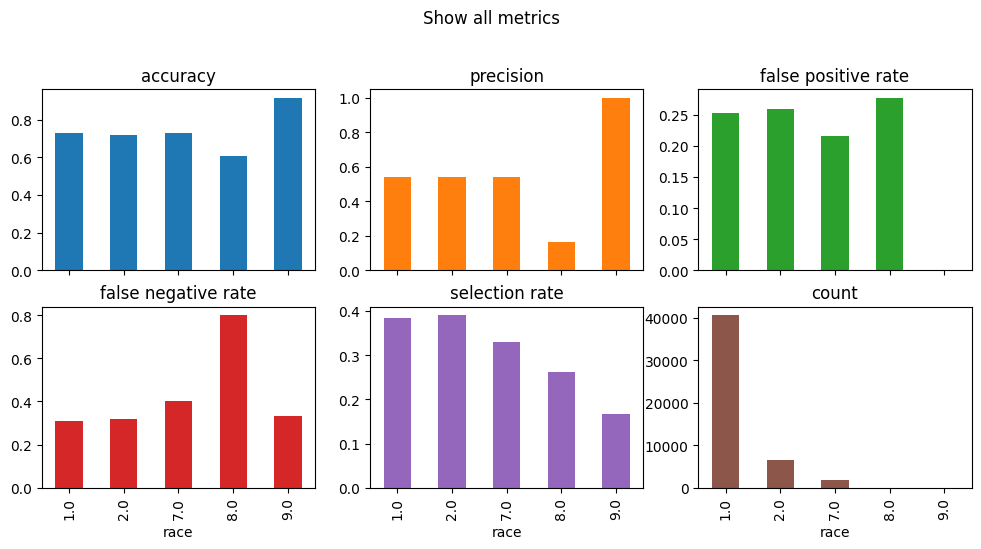

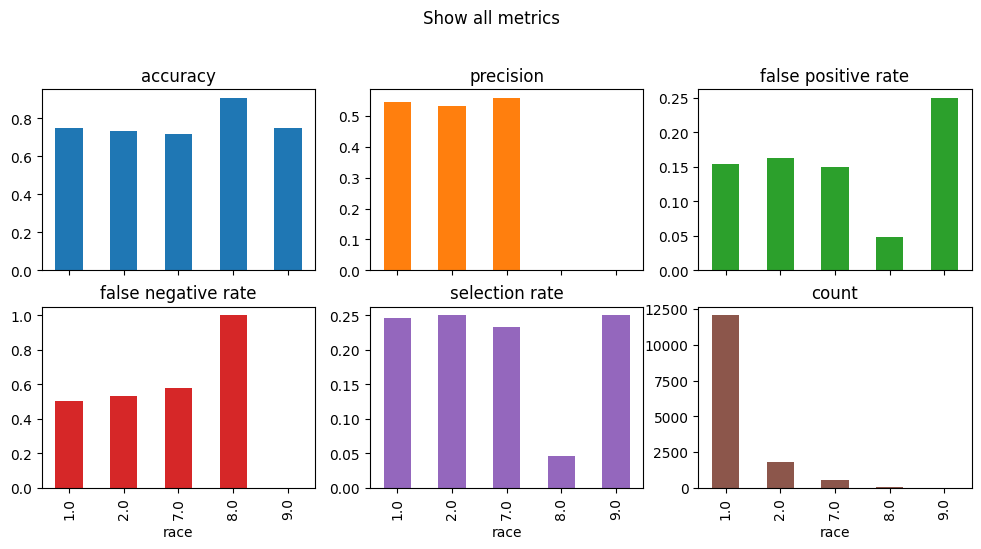

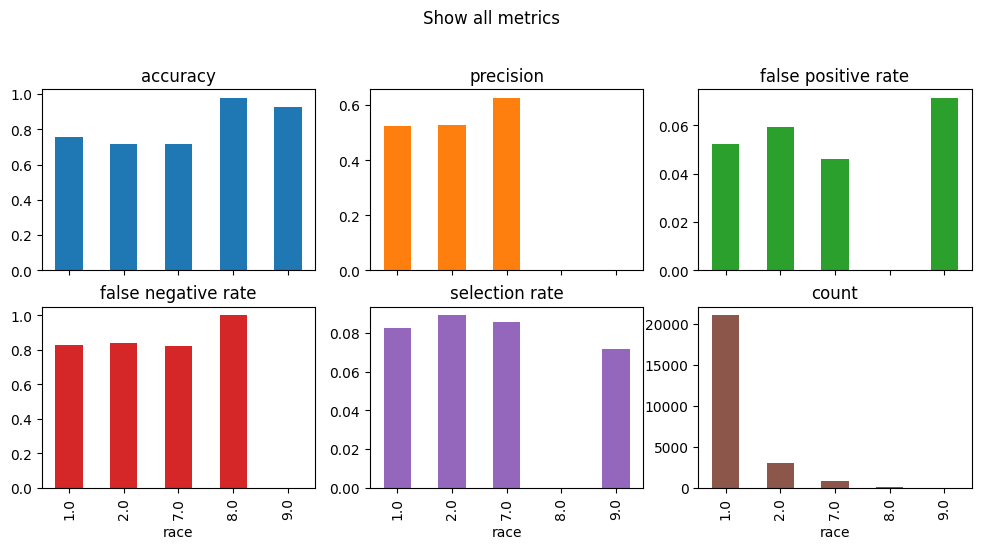

In [22]:
display_metrics(exp_gradient_mit.predict(X_train_imp_drop_normed), y_train_dropped, X_train_imp_dropped["race"])
display_metrics(exp_gradient_mit.predict(X_id_test_imp_drop_normed), y_id_test_dropped, X_id_test_imp_dropped["race"])
display_metrics(exp_gradient_mit.predict(X_ood_test_imp_drop_normed), y_ood_test_dropped, X_ood_test_imp_dropped["race"])

### Adversarial 

In [23]:
# ITERATIONS = 500 # note can't use the train_over_iterations because expotentiatedgradient doesnt allow for multiple fit() calls
#imputed_mlp_class = MLPClassifier(hidden_layer_sizes=(200,30), learning_rate_init=0.0007,
                                   # max_iter=1, warm_start=True, random_state=42)
# predictor_model = PredictorModel()
# ad_model = AdModel()
adv_clf = AdversarialFairnessClassifier(
    backend="torch",
    # predictor_model=[200,"relu",2,"sigmoid"], # this is number of nodes and then activation function, see here: https://fairlearn.org/main/api_reference/generated/fairlearn.adversarial.AdversarialFairnessClassifier.html#:~:text=a%20BackendEngine%20class.-,predictor_model,-list%2C%20torch.nn
    adversary_model= [3, "leaky_relu"],
    predictor_model=[200,"relu",20,"sigmoid"],
    # adversary_model=ad_model, 
    batch_size=32,
    learning_rate=0.0007,
    progress_updates=0.25,
    alpha=0.2,
    random_state=5,
    shuffle=True,
    epochs=7
    #contraints = "demographic_parity" # we can chagne this to equalized_odds as per https://fairlearn.org/main/api_reference/generated/fairlearn.adversarial.AdversarialFairnessClassifier.html#:~:text=constraintsstr%2C%20default,demographic_parity%E2%80%99%20or%20%E2%80%98equalized_odds%E2%80%99.
)


start = time.time()
adv_clf.fit(X_train_imp_drop_normed, y_train_dropped, sensitive_features=X_train_imp_dropped[EXP_GRAD_SENS_ATTR])
y_train_pred = adv_clf.predict(X_train_imp_drop_normed)
acc = accuracy_score(y_train_dropped, y_train_pred)

print(f"Accuracy: {acc}")
elapsed = time.time() - start
print(f"Time to execute: {elapsed}, it/s: {ITERATIONS/elapsed}")

# train_over_iterations(mitigator_f, X_train_imp_drop_normed,y_train_dropped, 20,
#                       sensitive_a_data = X_train_imp_dropped[EXP_GRAD_SENS_ATTR])

Accuracy: 0.7406470564236465
Time to execute: 56.19558048248291, it/s: 1.7794993688368723


tqdm jupyterlab-widgets ipywidgets torch

,metric_value
demo_parity_diff,0.223835
demo_parity_ratio,0.426801
eq_odds_diff,0.776876
eq_odds_ratio,0.000000
accuracy,0.740647


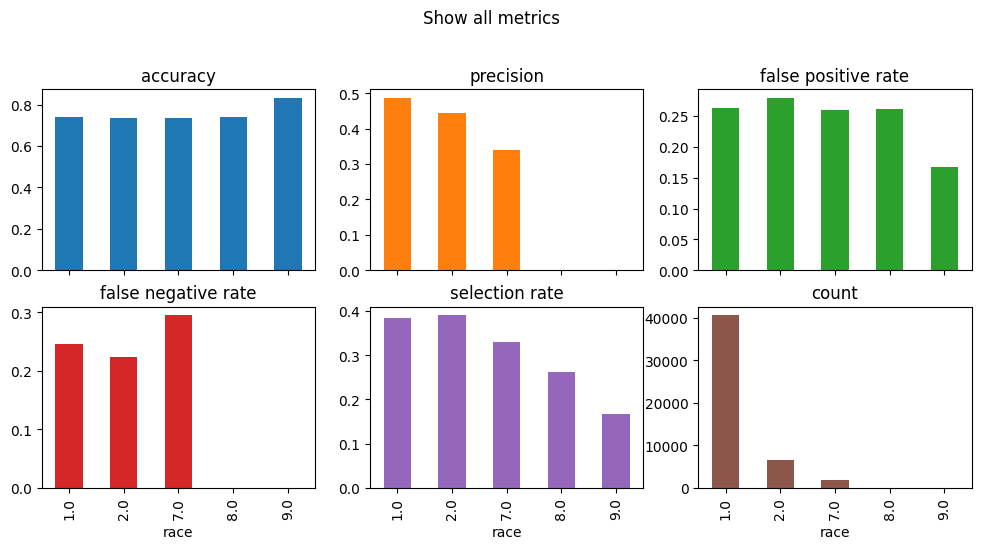

In [24]:
display_metrics(adv_clf.predict(X_train_imp_drop_normed), y_train_dropped, X_train_imp_dropped["race"])

,metric_value
demo_parity_diff,0.204545
demo_parity_ratio,0.181818
eq_odds_diff,0.544959
eq_odds_ratio,0.000000
accuracy,0.773437


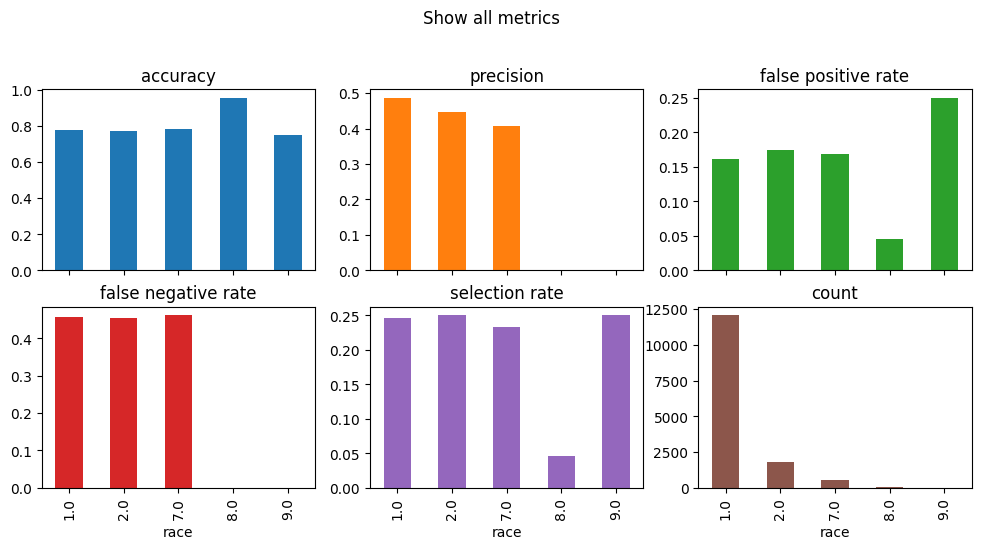

In [25]:
display_metrics(adv_clf.predict(X_id_test_imp_drop_normed), y_id_test_dropped, X_id_test_imp_dropped["race"])

,metric_value
demo_parity_diff,0.089119
demo_parity_ratio,0.000000
eq_odds_diff,0.217742
eq_odds_ratio,0.000000
accuracy,0.807725


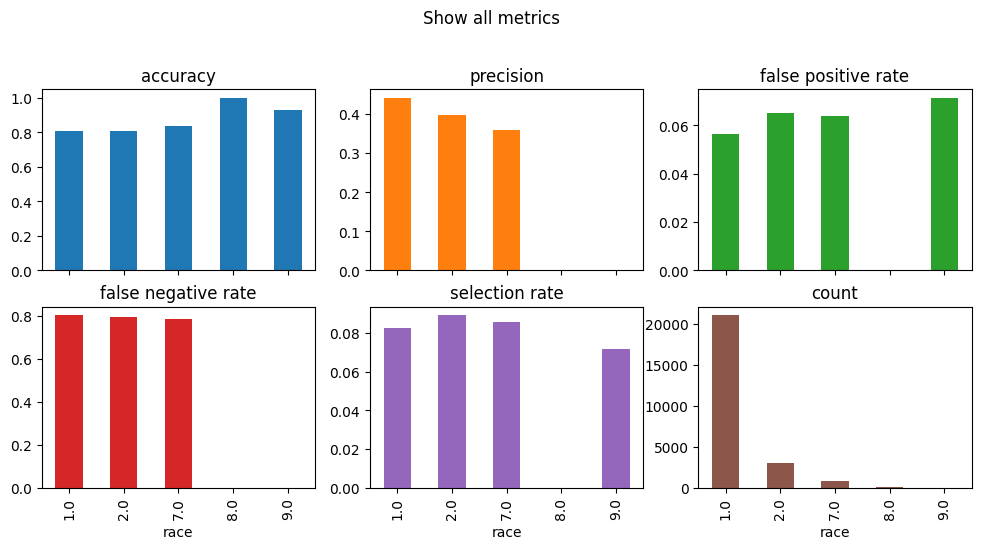

In [26]:
display_metrics(adv_clf.predict(X_ood_test_imp_drop_normed), y_ood_test_dropped, X_ood_test_imp_dropped["race"])